# Derivatives Portfolio Optimization and Parameter Uncertainty
This example is the accompanied code for the Derivatives Portfolio Optimization and Parameter Uncertainty article available at: https://ssrn.com/abstract=.

The example illustrates how to combine mean parameter uncertainty with Entropy Pooling for CVaR optimization and finally combine it with the Exposure Stacking method. For more on Portfolio Optimization and Parameter Uncertainty, see the original article introducing Exposure Stacking here: https://ssrn.com/abstract=4709317. You can find a video walkthrough of that article and the accompanying code here: https://youtu.be/P2vtg_A-JsY.

In [1]:
import numpy as np
import pandas as pd
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from copy import copy

In [2]:
# Load instrument info and pnl
pnl = ft.load_pnl()
prior_stats = ft.simulation_moments(pnl)
np.round(prior_stats, 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.096,3.023
Corp IG,-0.004,0.034,0.107,3.109
Corp HY,0.019,0.061,0.173,2.971
EM Debt,0.027,0.075,0.217,3.057
DM Equity,0.064,0.149,0.396,3.148
EM Equity,0.080,0.269,0.766,4.099
Private Equity,0.137,0.278,0.716,3.758
Infrastructure,0.059,0.108,0.311,3.193
Real Estate,0.043,0.081,0.234,3.092
Hedge Funds,0.048,0.072,0.204,3.050


In [3]:
# Compute covariance matrix for resampling
covariance_matrix = ft.covariance_matrix(pnl).values
means = prior_stats['Mean'].values

In [4]:
# Price some options
put_90 = ft.put_option(1, 0.9, 0.16, 0, 1)
put_95 = ft.put_option(1, 0.95, 0.155, 0, 1)
put_atmf = ft.put_option(1, 1, 0.15, 0, 1)
call_atmf = ft.call_option(1, 1, 0.15, 0, 1)
call_105 = ft.call_option(1, 1.05, 0.145, 0, 1)
call_110 = ft.call_option(1, 1.1, 0.14, 0, 1)

# Compute relative P&L
S, I = pnl.shape
zeros_vec = np.zeros(S)
dm_equity_price = 1 + pnl['DM Equity'].values

put_90_pnl = np.maximum(zeros_vec, 0.9 - dm_equity_price) - put_90
put_95_pnl = np.maximum(zeros_vec, 0.95 - dm_equity_price) - put_95
put_atmf_pnl = np.maximum(zeros_vec, 1 - dm_equity_price) - put_atmf
call_atmf_pnl = np.maximum(zeros_vec, dm_equity_price - 1) - call_atmf
call_105_pnl = np.maximum(zeros_vec, dm_equity_price - 1.05) - call_105
call_110_pnl = np.maximum(zeros_vec, dm_equity_price - 1.1) - call_110

In [5]:
# Add option simulations to P&L
pnl['Put 90'] = put_90_pnl
pnl['Put 95'] = put_95_pnl
pnl['Put ATMF'] = put_atmf_pnl
pnl['Call ATMF'] = call_atmf_pnl
pnl['Call 105'] = call_105_pnl
pnl['Call 110'] = call_110_pnl

prior_stats2 = ft.simulation_moments(pnl)
np.round(prior_stats2, 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.096,3.023
Corp IG,-0.004,0.034,0.107,3.109
Corp HY,0.019,0.061,0.173,2.971
EM Debt,0.027,0.075,0.217,3.057
DM Equity,0.064,0.149,0.396,3.148
EM Equity,0.080,0.269,0.766,4.099
Private Equity,0.137,0.278,0.716,3.758
Infrastructure,0.059,0.108,0.311,3.193
Real Estate,0.043,0.081,0.234,3.092
Hedge Funds,0.048,0.072,0.204,3.050


# Specify CVaR optimization object

In [6]:
# Copy constraints from https://ssrn.com/abstract=4217884.
v = np.hstack((np.ones(I), [put_90, put_95, put_atmf, call_atmf, call_105, call_110]))
G = np.vstack((np.eye(len(v)), -np.eye(len(v))))
options_bounds = 0.5 * np.ones(6)
h = np.hstack((0.25 * np.ones(I), options_bounds, np.zeros(I), options_bounds))

alpha = 0.9
R = pnl.values
cvar_opt = ft.MeanCVaR(R, G, h, v=v, alpha=alpha)

# Resampled optimization

In [7]:
# Parameter uncertainty specification
B = 100  # Number of efficient frontiers
P = 5  # Number of portfolios used to span the efficient frontiers
pf_index = 2
N = 100  # Sample size for parameter estimation
np.random.seed(3)  # Fix results
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [8]:
# Base frontier with no parameter uncertainty
frontier = cvar_opt.efficient_frontier(P)
frontier_results = np.full((P, 2), np.nan)
means_full = prior_stats2['Mean'].values
frontier_results[:, 0] = means_full @ frontier
frontier_results[:, 1] = ft.portfolio_cvar(frontier, R)

In [9]:
# Mean uncertainty for the cash instruments
p = np.ones((S, 1)) / S
frontier_mean = np.full((len(v), P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)
for b in range(B):
    means_uncertainty = np.mean(return_sim[:, b, :], axis=0)
    q = ft.entropy_pooling(p, A=R[:, :10].T, b=means_uncertainty[:, np.newaxis])
    means_run = q.T @ R
    cvar_opt._expected_return_row = -matrix(np.hstack((means_run, np.zeros((1, 2)))))
    frontier_mean[:, :, b] = cvar_opt.efficient_frontier(P)
    mean_results[:, 0, b] = means_full @ frontier_mean[:, :, b]
    mean_results[:, 1, b] = ft.portfolio_cvar(frontier_mean[:, :, b], R)

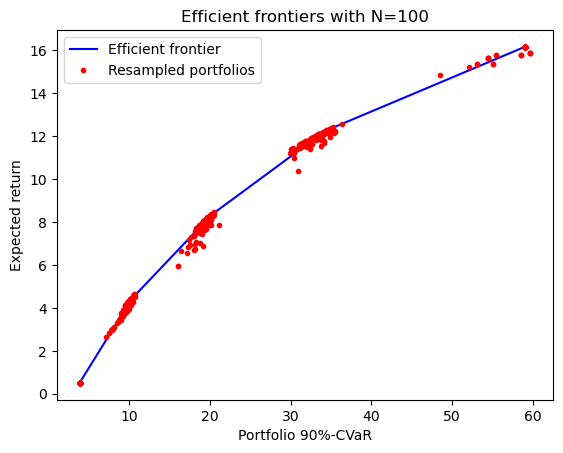

In [10]:
plt.plot(100 * frontier_results[:, 1], 100 * frontier_results[:, 0], 'b-')
plt.plot(100 * mean_results[:, 1, :], 100 * mean_results[:, 0, :], 'r.')
plt.legend(['Efficient frontier', 'Resampled portfolios'])
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio 90%-CVaR')
plt.show()

# Exposure Stacking
We implement the new Exposure Stacking method and test it against out-of-sample means and variances. As can be seen, Exposure Stacking has potential for better risk-adjusted returns than the traditional resampling method.

In [11]:
def exposure_stacking(L, frontier, num_samples):
    """Computes the L-fold Exposure Stacking.

    Partitions the first num_samples samples from the frontier into L sets 
    of equal size and computes the L-fold Exposure Stacking.

    Args:
        L: Number of partition sets.
        frontier: Resampled exposures frontier with shape (I, P, B).
        num_samples: Number of samples to include.

    Returns:
        Exposure Stacking portfolio.    
    """
    partition_size = num_samples // L  # If L does not divide num_bootstraps "remainder data" is not used.
    M = frontier[:, pf_index, :num_samples].T
    P = np.zeros((num_samples, num_samples))
    q = np.zeros((num_samples, 1))
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q = q + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    P = matrix(2 * partition_size * P)
    q = matrix(-2 * q)
    # Weights must sum to one
    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))
    # Weights must be nonnegative
    G = matrix(-np.identity(num_samples))
    h = matrix(np.zeros((num_samples, 1)))
    sol = solvers.qp(P, q, G, h, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    return exposure

In [12]:
re_pf = np.mean(frontier_mean[:, pf_index, :], axis=1)
exposure_2 = exposure_stacking(2, frontier_mean, B)

In [13]:
exposures_for_display = np.round(np.vstack((re_pf, exposure_2, frontier[:, pf_index])) * 100, 2).T
pd.DataFrame(
    exposures_for_display,
    index=prior_stats2.index,
    columns=['Resampled', '2-fold', 'Frontier portfolio'])

,Resampled,2-fold,Frontier portfolio
Gov & MBS,1.36,0.00,0.00
Corp IG,-0.00,-0.00,0.00
Corp HY,0.03,0.00,-0.00
EM Debt,12.56,11.50,12.39
DM Equity,5.30,0.00,-0.00
EM Equity,0.12,0.00,0.00
Private Equity,12.77,12.03,10.28
Infrastructure,21.32,25.00,25.00
Real Estate,17.72,21.81,22.23
Hedge Funds,24.17,25.00,25.00


# License

In [14]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2024 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.